<a href="https://colab.research.google.com/github/Skyrub-dev/BT_AI/blob/main/BT_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **L6 End-of-year project**

**Import Files**

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive/MyDrive/data')

ValueError: ignored

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Alternatively, through a local machine**

In [ ]:
local_dir = '../Archive'

Before proceeding, check that the directory can be found

In [ ]:
os.listdir(local_dir)

NameError: ignored

**Importing libraries**

---



In [2]:
import os
import tensorflow as tf
import cv2 #checkout open cv
import imghdr #allows to check file extensions for images
from matplotlib import pyplot as plt
import numpy as np
#import scipy
#from sklearn.model_selection import train_test_split
#import kaggle - will likely change

from tensorflow import keras
from tensorflow.python.keras import layers
from tensorflow.python.keras.models import sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

GPU check optimisation

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

CPU / GPU debug

In [ ]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

**If running off a local machine, this line of code must be run to install all dependencies**

---



In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib #! || % at the beginning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 MB 3.5 MB/s eta 0:00:00


**Importing and loading the data**

---



To import our data, we're going to be using an approach known as "Supervised learning". This is defined through pre-labelled datasets which the AI will be trained on. This is the best approach to solve a classification problem as the model can adjust itself and learn from its mistakes.

https://www.youtube.com/watch?v=_L2uYfVV48I

This is something that you do only for toy datasets or small sample sets. In the reality using image data generator is not recommended when you have huge volumes of images or video frames (which is usually the case). In those cases is a good practice to load and split the data across multiple tfrecords, then loading it progressively with tf.data and perform multithreaded augmentations dynamically during training. The majority of the augmentations can be computed using low level tf or common python functions.

In [21]:
labels = ['giloma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

**Loading the images**

---



**When using Colab, run the following lines of code from Google drive**

In [3]:
testing_path = '/content/drive/MyDrive/data/archive/Testing'
training_path = '/content/drive/MyDrive/data/archive/Training'
validation_path = '/content/drive/MyDrive/data/archive/Validation'

**If using the downloaded local file, run these lines of code**

In [ ]:
testing_path = '../Archive/Testing/'
training_path = '../Archive/Training/'
validation_path = '../Archive/Validation/'

Do **NOT** run them both, this will cause errors, only run the one which is applicable to you

Splitting data into testing, training and validation

In [ ]:
testgen = tf.keras.preprocessing.image_dataset_from_directory(
    directory = testing_path,
    labels = 'inferred',
    label_mode= 'categorical',
    class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
    batch_size = 32,
    image_size = (150, 150),
    shuffle = True
)

traingen = tf.keras.preprocessing.image_dataset_from_directory(
    directory = training_path,
    labels = 'inferred',
    label_mode= 'categorical',
    class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
    batch_size = 32,
    image_size = (150, 150),
    shuffle = True
)

validgen = tf.keras.preprocessing.image_dataset_from_directory(
    directory = validation_path,
    labels = 'inferred',
    label_mode= 'categorical',
    class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
    batch_size = 32,
    image_size = (150, 150),
    shuffle = True
)

Found 394 files belonging to 4 classes.
Found 2870 files belonging to 4 classes.


ValueError: The `class_names` passed did not match the names of the subdirectories of the target directory. Expected: [], but received: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [4]:
#https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

img_size = 150 #Likely not necessary but could be used

classes = 4
#Normalising pixel values to be between 0 and 1
testing_data_generator = ImageDataGenerator(rescale = 1./255)
training_data_generator = ImageDataGenerator(rescale = 1./255)
validation_data_generator = ImageDataGenerator(rescale = 1./255)

testing_generator = testing_data_generator.flow_from_directory (testing_path,
                                                                target_size = (150, 150),
                                                                color_mode = 'rgb',
                                                                save_format = 'jpg',
                                                                batch_size = 32,
                                                                class_mode = 'categorical', #Automatically converts the class labels to a one-hot encoded form
                                                                classes = ['giloma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

#Need to check these two and make sure they're configured correctly

training_generator = training_data_generator.flow_from_directory (training_path,
                                                                target_size = (150, 150),
                                                                color_mode = 'rgb',
                                                                save_format = 'jpg',
                                                                batch_size = 32,
                                                                class_mode = 'categorical',
                                                                shuffle = True, #Prevents overfitting but when evaluating model keep the data in its original order
                                                                subset = 'training',
                                                                #validation_split = 0.2,
                                                                classes = ['giloma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

validation_generator = testing_data_generator.flow_from_directory (validation_path,
                                                                target_size = (150, 150),
                                                                color_mode = 'rgb',
                                                                save_format = 'jpg',
                                                                batch_size = 32,
                                                                class_mode = 'categorical',
                                                                shuffle = True,
                                                                subset = 'validation',
                                                                classes = ['giloma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])


Found 294 images belonging to 4 classes.
Found 2044 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


Grabs data from the batch

In [29]:
batch = images, labels = next(training_generator)

In [28]:
testing_generator.class_indices.keys() # https://stackoverflow.com/questions/48373685/keras-imagedatagenerator-how-to-get-all-labels-from-data#51652128

dict_keys(['giloma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'])

In [ ]:
num_images = images.shape[0] #May remove

In [6]:
ground_truth_labels = ['giloma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [ ]:
#NEED TO REWORK THIS - JUST AN EXAMPLE
for i in range(num_images):
  image = images[i]
  label = labels[i]

  label_index = label.argmax()

  class_name = ['giloma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'][label_index]

  plt.imshow(image)
  plt.title(class_name)
  plt.show()

IGNORE THIS BECAUSE IT'S WRONG
Image 4 is correctly labelled as pituitary_tumor


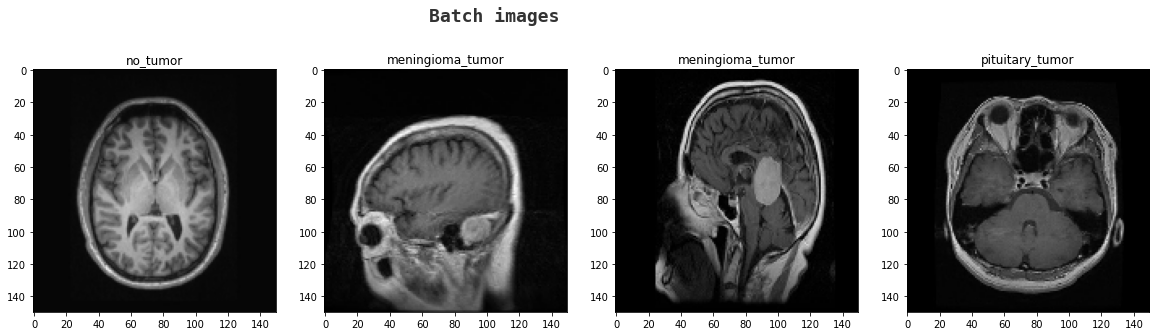

In [30]:
#for i in range(num_images):
  

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
fig.text(s='Batch images', size = 18, fontweight = 'bold', fontname = 'monospace', y=0.62, x=0.4, alpha=0.8)
for i in range(4):
  image = images[i]
  label = labels[i]
  label_index = label.argmax()
  class_name = ['giloma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'][label_index]
  ax[i].imshow(images[i])
  ax[i].set_title(class_name)

if class_name == ground_truth_labels[i]:
    print(f"IGNORE THIS BECAUSE IT'S WRONG")
    print(f"Image {i + 1} is correctly labelled as {class_name}")
else:
    print(f"Image {i + 1} is incorrectly labelled as {class_name}, the ground truth label is {ground_truth_labels[i]}")
#plt.imshow(image)
#plt.title(class_name)
#plt.show()
#for idx, img in enumerate(batch[0][:4]):
  #ax[idx].imshow(image)
  #ax[idx].title.set_text(class_name)

Build the model

In [ ]:
for images, labels in testgen.batch(batch_size = 32):
    

In [ ]:
x = testing_generator.next()

NameError: name 'scipy' is not defined

In [ ]:
testing_path[1]

'.'

In [ ]:
tf.keras.utils.to_categorical(testing_data_generator, num_classes=4, dtype="uint8")

NameError: name 'testing_data_generator' is not defined

Test code below, can delete or use as backup if things go wrong

In [ ]:
training = []
training_label = []

testing = []
testing_label = []

#test_path = os.listdir('/content/drive/MyDrive/data/archive/Training')

for i in testing_path:
  image = cv2.imread(testing_path, cv2.IMREAD_COLOR)
  image = cv2.resize(image, (150, 150))
  image = image / 255.0 #normalisation if above chunk of code works, will likely not need to apply this
  testing.append(image)
  testing_label.append(labels)

error: ignored

Next I'll likely use Keras’ ImageDataGenerator function to augment the dataset

In [ ]:
#Example: https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/
#src_path_train = "data/train/"
#src_path_test = "data/test/"

#adjust this function

data_agument = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.05,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.20
)

#train_datagen = ImageDataGenerator(
        #rescale=1 / 255.0,
        #rotation_range=20,
        #zoom_range=0.05,
        #width_shift_range=0.05,
        #height_shift_range=0.05,
        #shear_range=0.05,
        #horizontal_flip=True,
        #fill_mode="nearest",
        #validation_split=0.20)

#test_datagen = ImageDataGenerator(rescale=1 / 255.0)